In [82]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

import cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
import plotlib
import toolkit
import util
import test_phasing
from workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="counts_to_ase",
    experiment_info={"data" : "scDNA"},
    verbose=True
)
workspace.load_workspace()

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
data = {
    data_type : util.pickle_load(workspace.tmp_data[data_type])
    for data_type in ["counts", "gene_counts", "genome"]
}
data["snp"] = data["counts"]\
                [["CHROM", "POS"]]\
                .to_dense()\
                .astype(np.int64)

In [84]:
data["gene_counts"].shape

(12291, 537)

In [41]:
chrom_to_genes = {
    str(chrom) : data["genome"][data["genome"]["CHROM"] == chrom]
    for chrom in data["genome"]["CHROM"].unique()
}

In [42]:
data["genome"].shape

(18011, 4)

In [43]:
%%time

# Here gene coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def intersect_snp_with_genes(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellSNP is 1-based, but .bed files are 0-based
    genes_on_chrom = chrom_to_genes[str(chrom)]
    mask = ((genes_on_chrom.START <= pos) 
            & (pos < genes_on_chrom.END))
    return '@'.join(genes_on_chrom[mask].GENE_ID)

pool = mp.Pool(16)
result = pool.map(intersect_snp_with_genes, 
                  tqdm_notebook(data["snp"].values, 
                                "SNP processing"))
pool.close()
pool.join()

CPU times: user 3.48 s, sys: 6.92 s, total: 10.4 s
Wall time: 42.5 s


In [44]:
""" Here the raw results computed in parallel are parsed """
snp_to_genes, gene_to_snps = {}, OrderedDict()

# This way we ensure proper gene ordering
for gene_id in data["genome"].GENE_ID:
    gene_to_snps[gene_id] = []

for i, row in tqdm_notebook(enumerate(data["snp"].values), 
                            "mapping SNPs to genes"):
    chrom, pos = row
    snp = f"{chrom},{pos}"
    snp_to_genes[snp] = result[i].split("@") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)

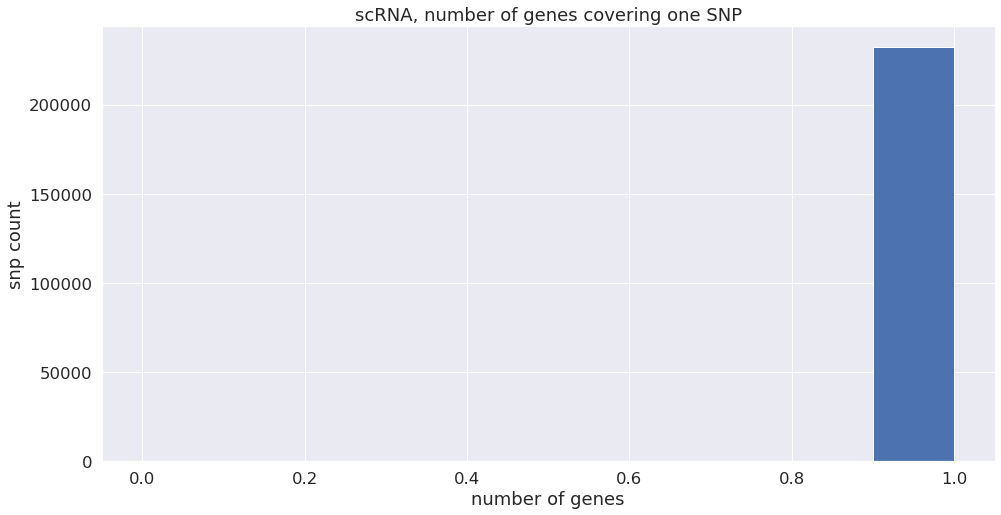

In [45]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title(f"{workspace.experiment_info['data']}, "
          "number of genes covering one SNP")
plt.xlabel("number of genes")
plt.ylabel("snp count")
plt.hist([len(gene_list) for gene_list in snp_to_genes.values()]);

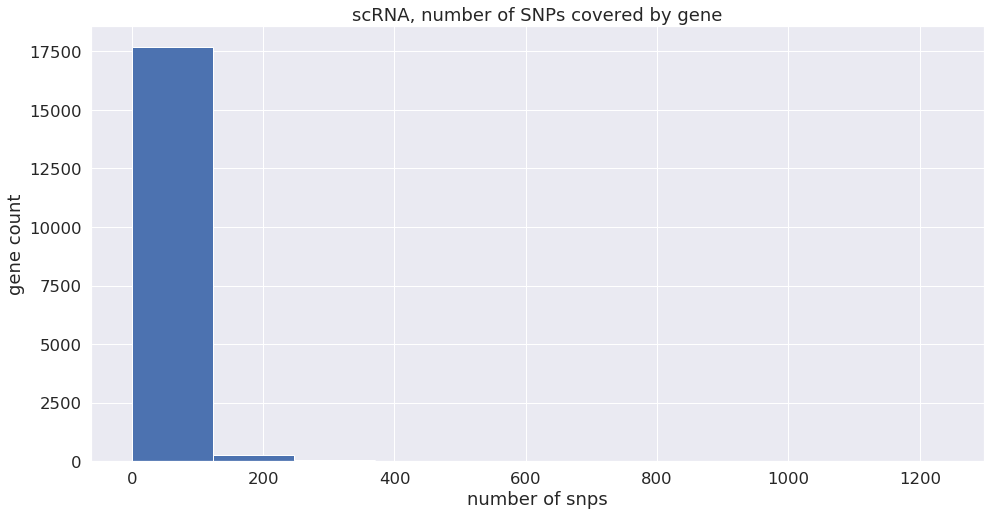

In [46]:
plt.figure(figsize=(16,8))
plt.title(f"{workspace.experiment_info['data']}"
          ", number of SNPs covered by gene")
plt.xlabel("number of snps")
plt.ylabel("gene count")
plt.hist([len(snp_list) for snp_list 
          in gene_to_snps.values()]);

In [47]:
util.pickle_dump(
    snp_to_genes, 
    f"{workspace.tmp_dir}/cnv_^_haplotype_block_snp_to_genes.pkl"
)
workspace.add_entry("cnv_^_haplotype_block_snp_to_genes", 
                    "cnv_^_haplotype_block_snp_to_genes.pkl")
util.pickle_dump(
    gene_to_snps, 
    f"{workspace.tmp_dir}/cnv_^_haplotype_block_gene_to_snps.pkl"
)
workspace.add_entry("cnv_^_haplotype_block_gene_to_snps", 
                    "cnv_^_haplotype_block_gene_to_snps.pkl")

In [48]:
workspace.status()

Staged for commit: 
	-cnv_^_haplotype_block_snp_to_genes : cnv_^_haplotype_block_snp_to_genes.pkl
	-cnv_^_haplotype_block_gene_to_snps : cnv_^_haplotype_block_gene_to_snps.pkl


In [49]:
data["counts"] = util.pickle_load(workspace.tmp_data["counts"])

In [50]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(toolkit.extract_snps(data["counts"])), 
                            "mapping snps to their index numbers "
                            "by position in the genome")}

In [51]:
%%time

gene_to_snp_ids = {gene : np.array([snp_to_idx[snp] for snp in snp_list]) 
                   for gene, snp_list 
                   in tqdm_notebook(gene_to_snps.items(), 
                                    desc="mapping gene to SNP ids"
                                    " (for faster row selection)")}

def extract_gene_counts(barcode):
    gene_to_ad, gene_to_dp = [], []
    # I need to convert these columns to dense format
    # because I need only a subset of rows on each iteration 
#     male_alt = data["counts"]["PHASE"].to_dense() == 1
    ad = data["counts"][f"{barcode}_ad"].to_dense()
    dp = data["counts"][f"{barcode}_dp"].to_dense()
#     ad[male_alt] = dp[male_alt].sub(ad[male_alt], fill_value=0)
    ad = ad.values
    dp = dp.values
    # gene_to_snps is an OrderedDict, so we can guarantee
    # that all the genes are processed in a correct order
    for gene, snp_ids in gene_to_snp_ids.items():
        if len(snp_ids) > 0:
            ad_sample, dp_sample = ad[snp_ids], dp[snp_ids]
            gene_to_ad.append(np.nan  if np.all(np.isnan(ad_sample)) 
                                      else np.nansum(ad_sample))
            gene_to_dp.append(np.nan  if np.all(np.isnan(dp_sample)) 
                                      else np.nansum(dp_sample))
    return pd.DataFrame({f"{barcode}_ad" : gene_to_ad, 
                         f"{barcode}_dp" : gene_to_dp})

with mp.Pool(16) as pool:
    result_list = pool.map(
        extract_gene_counts, 
        tqdm_notebook(toolkit.extract_barcodes(data["counts"]), 
                      desc="cell_barcode processing")
    )
    
gene_counts_df = pd.concat(result_list, axis=1).to_dense()
gene_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8779 entries, 0 to 8778
Columns: 13338 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: float64(13338)
memory usage: 893.4 MB
CPU times: user 10.5 s, sys: 11.7 s, total: 22.1 s
Wall time: 1min 48s


In [52]:
gene_counts_df.insert(
    0, "GENE_ID", 
    [gene for gene, snp_list 
     in gene_to_snps.items() 
     if len(snp_list) > 0]
)
toolkit.assert_gene_ordering(gene_counts_df, data["genome"])
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,23.0,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [53]:
data["clustering"] = util.pickle_load(f"{workspace.tmp_dir}/clustering.pkl")

In [54]:
clean_barcodes = data["clustering"]["BARCODE"]
raw_barcodes = toolkit.extract_barcodes(gene_counts_df)
noisy_barcodes = np.setdiff1d(raw_barcodes, clean_barcodes)
gene_counts_df.drop(
    columns=[f"{barcode}_ad" for barcode in noisy_barcodes],
    inplace=True
)
gene_counts_df.drop(
    columns=[f"{barcode}_dp" for barcode in noisy_barcodes],
    inplace=True
)

In [55]:
util.pickle_dump(
    gene_counts_df,
    os.path.join(
        workspace.tmp_dir,
        "cnv_^_haplotype_block_gene_counts.pkl"
    )
)
workspace.add_entry("cnv_^_haplotype_block_gene_counts", 
                    "cnv_^_haplotype_block_gene_counts.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scRNA/cnv_^_haplotype_block_snp_to_genes.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scRNA/cnv_^_haplotype_block_snp_to_genes.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scRNA/cnv_^_haplotype_block_gene_to_snps.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scRNA/cnv_^_haplotype_block_gene_to_snps.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scRNA/cnv_^_haplotype_block_gene_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scRNA/cnv_^_haplotype_block_gene_counts.pkl


In [61]:
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCTCCG-1_ad,AAACCTGGTAGCTCCG-1_dp,AAACCTGGTCTAAACC-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,23.0,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
